<a href="https://colab.research.google.com/github/arkham1994/Deep-Learning/blob/main/Image_Segmentation_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Eyes and Lips Image Segmentation 

In [48]:
# Importing all the required libraries

import os
import cv2
import sys
import random
import numpy as np
import tensorflow as tf 
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt 
from keras.models import Model, load_model
from skimage.transform import resize

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from shutil import copyfile
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import save_img

np.random.seed = 42





#### 1. Uploading data on Google drive

In [14]:
# Connecting with Google Drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Making Colab Notebooks as current directory

%cd /content/drive/My Drive/Colab Notebooks   

/content/drive/My Drive/Colab Notebooks


In [ ]:
# Unzipping the zip file into my directory
# No need to execute again 

!unzip CelebAMask-HQ.zip

In [6]:
# Making new Folder to store all the combined mask of eyes and lips for each unique image
# No need to execute again

os.mkdir('Img_Masks')

In [7]:
# Checking if the path exists

os.path.exists('/content/drive/My Drive/Colab Notebooks/Img_Masks')

True

###2. Generating combined masks

In [ ]:
# Here I have generated combined eyes and lips masks for each unique image(only first 2000)


for i in range(0,2000):

        # Changing path for different images
        if i <10:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/0000'
        elif i<100:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/000'
        elif i <1000: 
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/00'
        elif i<10000:
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/0'
        else: 
            path =  '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'    
            
        if os.path.isfile(path + '{}_l_lip.png'.format(i)) and os.path.isfile(path + '{}_u_lip.png'.format(i)) and os.path.isfile(path + '{}_l_eye.png'.format(i)) and os.path.isfile(path + '{}_r_eye.png'.format(i)):
            
            # Here we are taking maximum pixel values from all the four images( u_lip, l_lip, l_eye, u_eye) and making it one image
            im1=imread(path + '{}_l_lip.png'.format(i))
            im2=imread(path + '{}_u_lip.png'.format(i))
            im3=imread(path + '{}_l_eye.png'.format(i)) 
            im4=imread(path + '{}_r_eye.png'.format(i))
            im5=np.maximum(np.asarray(im1),np.asarray(im2))
            im6=np.maximum(np.asarray(im3),np.asarray(im4))
            im7=np.maximum(np.asarray(im5),np.asarray(im6))
        
        save_path = '/content/drive/My Drive/Colab Notebooks/Img_Masks/'
        
        # Saving the created masks at our new Folder
        save_img(save_path + 'mask{}.png'.format(i), im7)

        

Defining the basic parameters and training and testing size

In [8]:
# Width and Height of the input image
# This parameters can be changed according to computational power

img_width = 128
img_height = 128
img_channel = 3

In [9]:
# Generating empty arrays for training and testing data
# Taking 1800 images in training data
# Taking 200 images in testing data

X_train = np.zeros((1800, img_height, img_width, img_channel), dtype=np.uint8)   
Y_train = np.zeros((1800, img_height, img_width, 1), dtype= bool)
X_test = np.zeros((200, img_height, img_width, img_channel), dtype=np.uint8)

###3. Model Building

In [42]:
# Bulding the model for Eyes and Lips Segmentation based on U-Net architecture


inputs = tf.keras.layers.Input((img_width, img_height, img_channel))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

# Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding = 'same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding = 'same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
 
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
____________________________________________________________________________________________

###4. Generating the X_train, X_test and Y_train

In [ ]:
# Loading 1800 Training images data into X_train array

folder = '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebA-HQ-img/'

def load_train_images_from_folder(folder):
    images = []
    for i in tqdm(range(0,1800)):
        img = imread(os.path.join(folder,'{}.jpg'.format(i)))[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_train[i] = img
        
    return None 

load_train_images_from_folder(folder)

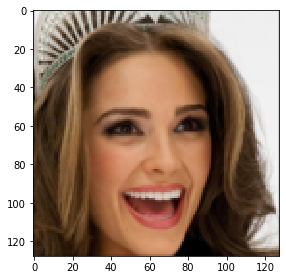

In [23]:
imshow(X_train[0])
plt.show()

In [ ]:
# Loading 200 Training images data into X_test array

folder = '/content/drive/My Drive/Colab Notebooks/CelebAMask-HQ/CelebA-HQ-img/'
def load_test_images_from_folder(folder):
    
    for i in tqdm(range(1800,2000)):
        img = imread(os.path.join(folder,'{}.jpg'.format(i)))[:,:,:img_channel]
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_test[i - 1800] = img
        
    return None 

load_test_images_from_folder(folder)

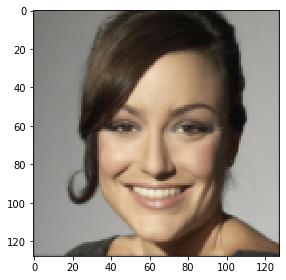

In [34]:
imshow(X_test[1])
plt.show()

In [ ]:
# Loading first 1800 mask images data into Y_train array

for i in tqdm(range(0,1800)):
    mask = np.zeros((img_height, img_width, 1), dtype = bool)
    path = '/content/drive/My Drive/Colab Notebooks/Img_Masks/'
    im_gray = cv2.imread(path + 'mask{}.png'.format(i), cv2.IMREAD_GRAYSCALE)
    im_gray = resize(im_gray, (img_height, img_width), mode='constant', preserve_range=True)
    im_gray = np.expand_dims(im_gray,axis=2)
    mask = np.maximum(mask, im_gray)
    Y_train[i] = mask
    

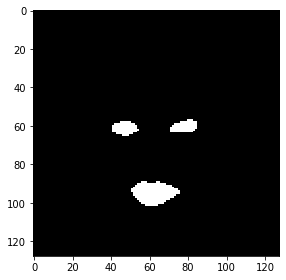

In [36]:
imshow(np.squeeze(Y_train[199]))

###5. Training the Model

In [43]:
# Model Checkpoint

checkpointer = tf.keras.callbacks.ModelCheckpoint('model_img_segmentation.h5', verbose = 1, save_best_only = True)

# This will save the best model and it will stop training once validation_loss is not improving much
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'), checkpointer]

# Training our model with 10 % data as validating data

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, callbacks = callbacks)

Epoch 1/100
51/51 [==============================] - 40s 110ms/step - loss: 0.2039 - mean_io_u: 0.4865 - val_loss: 0.0746 - val_mean_io_u: 0.4866

Epoch 00001: val_loss improved from inf to 0.07460, saving model to model_img_segmentation.h5
Epoch 2/100
51/51 [==============================] - 4s 76ms/step - loss: 0.0578 - mean_io_u: 0.4865 - val_loss: 0.0493 - val_mean_io_u: 0.4866

Epoch 00002: val_loss improved from 0.07460 to 0.04929, saving model to model_img_segmentation.h5
Epoch 3/100
51/51 [==============================] - 4s 76ms/step - loss: 0.0409 - mean_io_u: 0.4865 - val_loss: 0.0376 - val_mean_io_u: 0.4866

Epoch 00003: val_loss improved from 0.04929 to 0.03765, saving model to model_img_segmentation.h5
Epoch 4/100
51/51 [==============================] - 4s 76ms/step - loss: 0.0285 - mean_io_u: 0.4865 - val_loss: 0.0302 - val_mean_io_u: 0.4866

Epoch 00004: val_loss improved from 0.03765 to 0.03017, saving model to model_img_segmentation.h5
Epoch 5/100
51/51 [===========

In [45]:
# Loading the best model
model1 = load_model('/content/drive/My Drive/Colab Notebooks/model_img_segmentation.h5')

Predicting values for test data

In [46]:
# Predicting values for testing data

preds_test = model1.predict(X_test, verbose=1)

# Threshold predictions

preds_test_t = (preds_test > 0.5).astype(np.uint8)



7/7 [==============================] - 9s 27ms/step


###6. Results

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


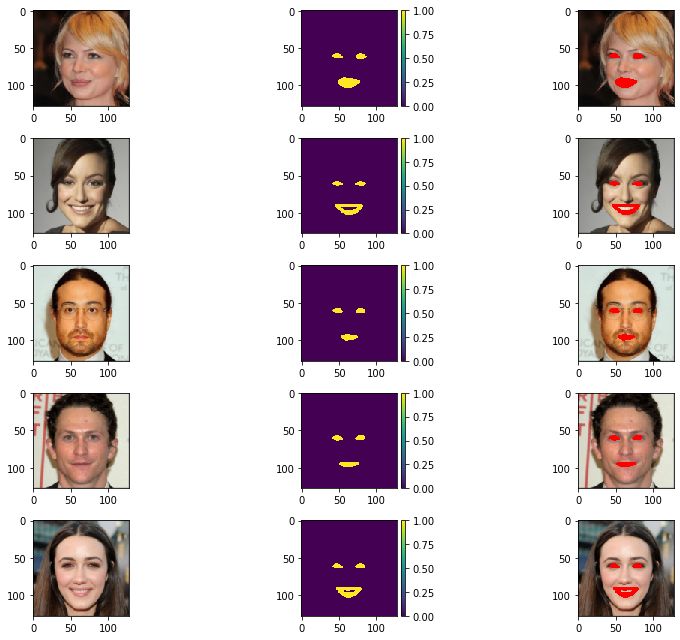

In [49]:
# Displaying the first 5 images from testing data, their predicted masks and the final masked images

fig=plt.figure(figsize=(15, 9))

for i in range(0,5):
  fig.add_subplot(5,3, 3*i+1)

  im1=deepcopy(X_test[i][:,:,:])
  imshow(im1)

  fig.add_subplot(5,3, 3*i+2)
  imshow(np.squeeze(preds_test_t[i])[:,:])

  fig.add_subplot(5,3, 3*i+3)
  im2=deepcopy(np.squeeze(preds_test_t[i])[:,:])

  for i in range(im2.shape[0]):
    for j in range(im2.shape[1]):

      if(im2[i,j]!=0):
        im1[i,j,:]=[255,0,0]
  imshow(im1)
plt.show()

###7. Discussion on training and validation metrics
1. Pixel accuracy 
   It is percent of pixels in your image that is correctly classified. It is easy to use but it is not the best evaluation metric.
   It gives inaccurate results when there is an imbalance in the classes.

2. Intersection-Over-Union (IoU, Jaccard Index) 
   IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the
   predicted segmentation and the ground truth. It is most commonly used and it give more reliable results than the Pixel accuracy.

3. Dice Coefficient (F1 Score)
   Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images. The Dice coefficient is very similar to the IoU

Both Dice coefficient and Iou can be used for evaluation of image segmentation.

###8. Discussion on Loss Functions

1. Dice Loss
   This loss is obtained by calculating smooth dice coefficient function. This loss is the most commonly used loss is segmentation problems.

2. Intersection over Union (IoU)-balanced Loss
   The IoU-balanced classification loss aims at increasing the gradient of samples with high IoU and decreasing the gradient of samples with low IoU.
   In this way, the localization accuracy of machine learning models is increased.

3. Weighted cross-entropy
   In this variant of cross-entropy, all positive examples are weighted by a certain coefficient. It is used in scenarios that involve class imbalance.  

4. Binary Cross Entropy
   It is used for Two class classification problems.

Any of the above loss functions can be used. We are using Binary Cross Entropy Loss in our notebook as we have two classes. 

###9. Hyperparameters
  1. Number of filters used at different layers
  2. Batch Size
  3. Activation function
  4. Kernel Initializer
  5. Loss function
  4. Validation Metric
  5. Optimizer
  6. Image size

The reason for using the values of parameters as mentioned in the notebook is that they were giving decent results and also image size is reduced for faster
computation.

The results can be improved when model is trained on all 30,000 images. Here I
have only used 1800 images.